In [1]:
import os
import random
import numpy as np
import tensorflow as tf
from skimage import io, exposure, color
from sklearn.model_selection import train_test_split
from PIL import Image, ImageOps
from PIL import Image, ImageEnhance
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

In [2]:
def plot_images(low_light_dir, enhanced_dir, num_images=5):
    low_light_images = os.listdir(low_light_dir)[:num_images]
    enhanced_images = os.listdir(enhanced_dir)[:num_images]
    
    plt.figure(figsize=(15, 10))

    for i, img_name in enumerate(low_light_images, 1):
        image_path = os.path.join(low_light_dir, img_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        plt.subplot(2, num_images, i)
        plt.imshow(image)
        plt.title(f'Low Light {i}')
        plt.axis('off')

    for i, img_name in enumerate(enhanced_images, 1):
        image_path = os.path.join(enhanced_dir, img_name)
        image = Image.open(image_path)
        image = image.resize((224, 224))
        plt.subplot(2, num_images, num_images + i)
        plt.imshow(image)
        plt.title(f'Enhanced {i}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [3]:
low_light_dir = '../input/lol-dataset/lol_dataset/our485/low'
enhanced_dir = '../input/lol-dataset/lol_dataset/our485/high'

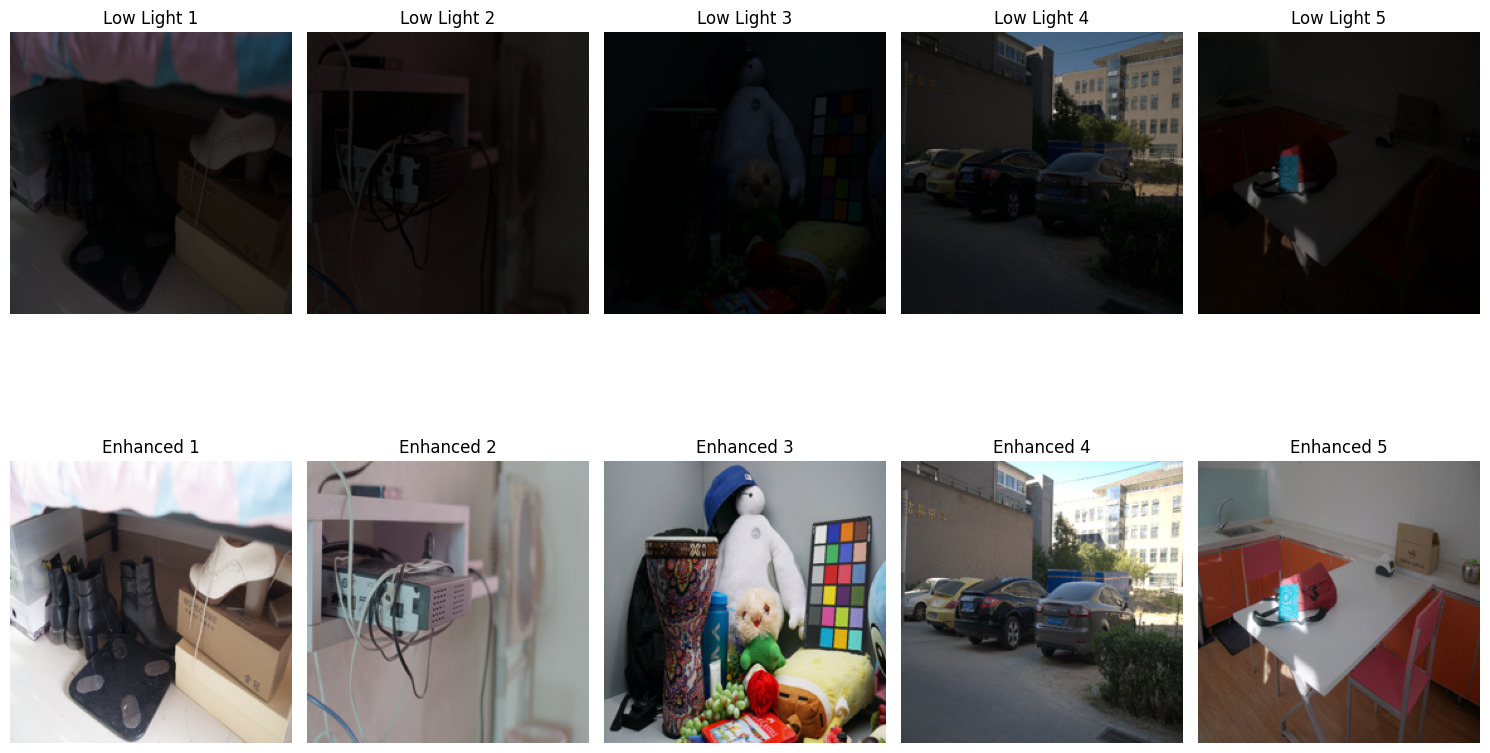

In [4]:
plot_images(low_light_dir, enhanced_dir, num_images=5)

# Pre-processing

In [7]:
def process_lowlight_images(image_dir):

    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    processed_images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image = ImageOps.autocontrast(image)
        image_resized = image.resize((600, 400))
        image_array = np.array(image_resized) / 255.0
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        processed_images.append(image_tensor)

    return np.array(processed_images)

In [9]:
low_light_images = process_lowlight_images(low_light_dir)

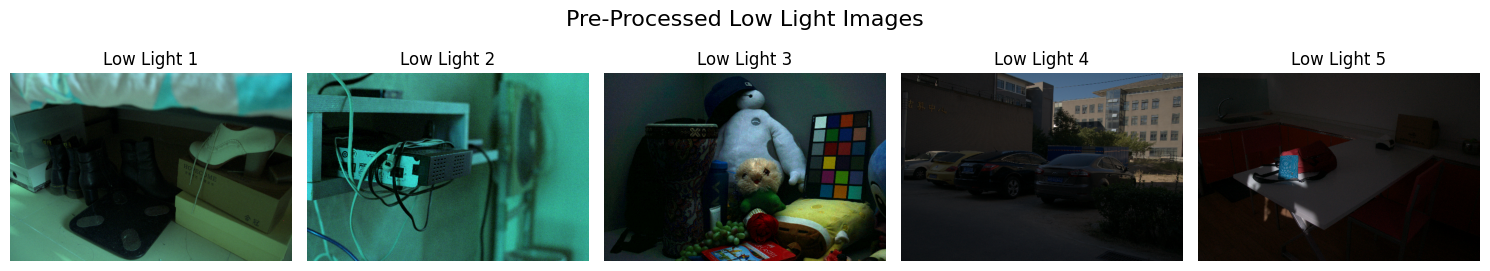

In [10]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()
fig.suptitle('Pre-Processed Low Light Images', fontsize=16)
for i, ax in enumerate(axes[:5]):
    ax.imshow(low_light_images[i])
    ax.set_title(f'Low Light {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=1.3)
plt.show()

In [11]:
def process_enhanced_images(image_dir):
    
    image_paths = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir) if filename.endswith(('.jpg', '.jpeg', '.png'))]
    
    processed_images = []
    for image_path in image_paths:
        image = Image.open(image_path)
        image_resized = image.resize((600, 400))
        image_array = np.array(image_resized) / 255.0
        image_tensor = tf.convert_to_tensor(image_array, dtype=tf.float32)
        processed_images.append(image_tensor)

    return np.array(processed_images)

In [12]:
enhanced_images = process_enhanced_images(enhanced_dir)

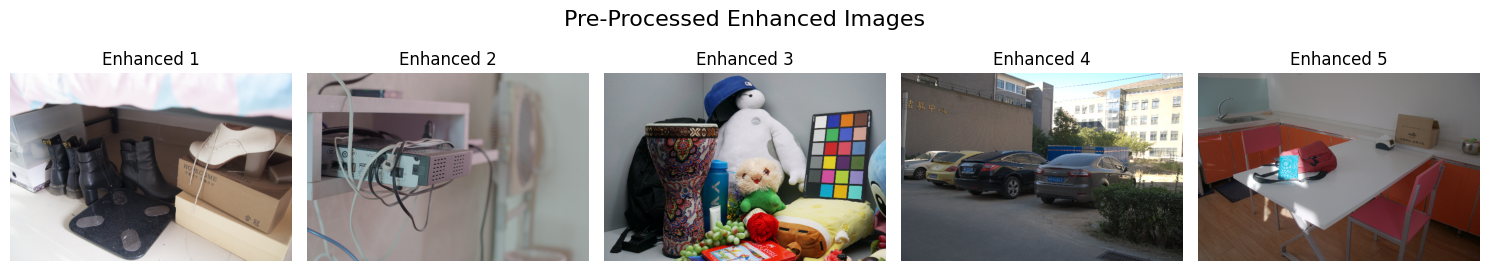

In [13]:
fig, axes = plt.subplots(1, 5, figsize=(15, 5))
axes = axes.flatten()
fig.suptitle('Pre-Processed Enhanced Images', fontsize=16)
for i, ax in enumerate(axes[:5]):
    ax.imshow(enhanced_images[i])
    ax.set_title(f'Enhanced {i + 1}')
    ax.axis('off')

plt.tight_layout()
plt.subplots_adjust(top=1.3)
plt.show()

In [14]:
x_train, x_test, y_train, y_test = train_test_split(low_light_images, enhanced_images, test_size=0.2, random_state=18)

# Modelling

## Autoencoder

In [16]:
def build_autoencoder_v2(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(32, 3, activation='relu', strides=2, padding='same')(inputs)
    conv2 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(conv1)
    conv3 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(conv2)

    # Bottleneck
    bottleneck = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)

    # Decoder
    up1 = tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(bottleneck)
    up2 = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(up1)
    up3 = tf.keras.layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(up2)
    
    outputs = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(up3)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [17]:
autoencoder_v2 = build_autoencoder_v2(input_shape=(400, 600, 3))
autoencoder_v2.compile(optimizer='adam', loss='mse')

In [18]:
autoencoder_v2.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 400, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 200, 300, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 100, 150, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 50, 75, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 50, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 100, 150, 128)       │         295,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 200, 300, 64)        │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 400, 600, 32)        │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 400, 600, 3)         │             867 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 776,579 (2.96 MB)

 Trainable params: 776,579 (2.96 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
history = autoencoder_v2.fit(x_train, y_train, epochs=25, batch_size=4, validation_data=(x_test, y_test))

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 26s 124ms/step - loss: 0.0455 - val_loss: 0.0301
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0316 - val_loss: 0.0242
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - loss: 0.0282 - val_loss: 0.0258
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 0.0264 - val_loss: 0.0293
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step - loss: 0.0262 - val_loss: 0.0274
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 78ms/step - loss: 0.0263 - val_loss: 0.0254
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 79ms/step - loss: 0.0259 - val_loss: 0.0269
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0251 - val_loss: 0.0262
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - loss: 0.0257 - val_loss: 0.0258
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 82ms/step - loss: 0.0265 - val_loss: 0.0244
Epoch 11/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0.0241 - val_loss: 0.0226
Epoch 12/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 8s 83ms/step - loss: 0

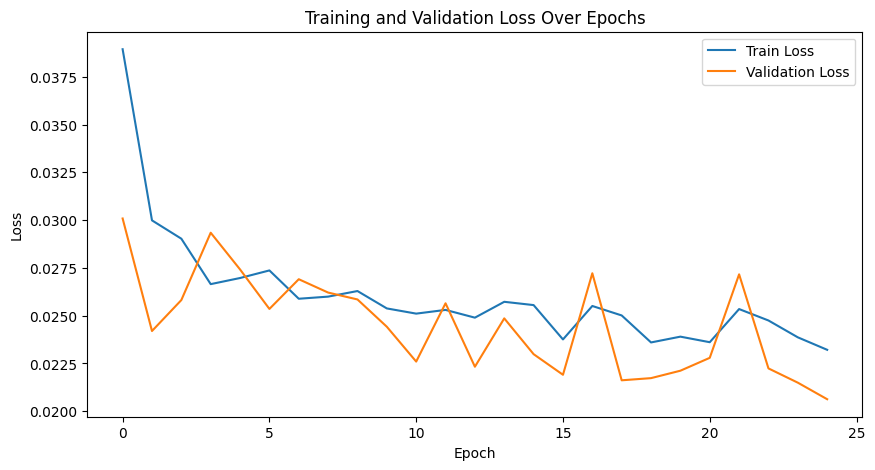

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


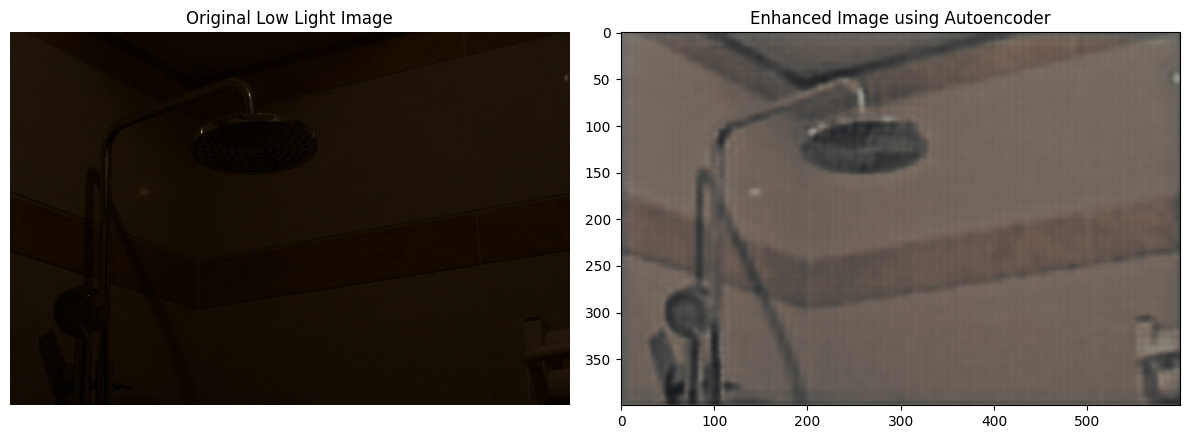

In [25]:
sample_index = 1
sample_image = x_test[sample_index]

sample_image = np.expand_dims(sample_image, axis=0)
enhanced_image = autoencoder_v2.predict(sample_image)
enhanced_image = np.squeeze(enhanced_image, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_test[sample_index])
plt.title('Original Low Light Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title('Enhanced Image using Autoencoder')
plt.tight_layout()
plt.show()

## Dense Autoencoder

In [34]:
def build_dense_autoencoder(input_shape):
    inputs = tf.keras.layers.Input(shape=input_shape)

    # Encoder
    conv1 = tf.keras.layers.Conv2D(64, 3, activation='relu', strides=2, padding='same')(inputs)
    conv2 = tf.keras.layers.Conv2D(128, 3, activation='relu', strides=2, padding='same')(conv1)
    conv3 = tf.keras.layers.Conv2D(256, 3, activation='relu', strides=2, padding='same')(conv2)
    conv4 = tf.keras.layers.Conv2D(512, 3, activation='relu', strides=2, padding='same')(conv3)
    conv5 = tf.keras.layers.Conv2D(1024, 3, activation='relu', strides=2, padding='same')(conv4)

    # Bottleneck
    bottleneck = tf.keras.layers.Conv2D(2048, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up1 = tf.keras.layers.Conv2DTranspose(1024, 3, activation='relu', strides=2, padding='same')(bottleneck)
    up2 = tf.keras.layers.Conv2DTranspose(512, 3, activation='relu', strides=2, padding='same')(up1)
    up3 = tf.keras.layers.Conv2DTranspose(256, 3, activation='relu', strides=2, padding='same')(up2)
    up4 = tf.keras.layers.Conv2DTranspose(128, 3, activation='relu', strides=2, padding='same')(up3)
    up5 = tf.keras.layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(up4)

    # Output layer 
    outputs = tf.keras.layers.Conv2D(3, 3, activation='sigmoid', padding='same')(up5)
    outputs = tf.keras.layers.Resizing(400, 600)(outputs)
    model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
    return model

In [35]:
dense_autoencoder = build_dense_autoencoder(input_shape=(400, 600, 3))
dense_autoencoder.compile(optimizer='adam', loss='mse')

In [36]:
dense_autoencoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 400, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 200, 300, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_20 (Conv2D)                   │ (None, 100, 150, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_21 (Conv2D)                   │ (None, 50, 75, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_22 (Conv2D)                   │ (None, 25, 38, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_23 (Conv2D)                   │ (None, 13, 19, 1024)        │       4,719,616 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_24 (Conv2D)                   │ (None, 13, 19, 2048)        │      18,876,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_13                  │ (None, 26, 38, 1024)        │      18,875,392 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_14                  │ (None, 52, 76, 512)         │       4,719,104 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_15                  │ (None, 104, 152, 256)       │       1,179,904 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_16                  │ (None, 208, 304, 128)       │         295,040 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_17                  │ (None, 416, 608, 64)        │          73,792 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_25 (Conv2D)                   │ (None, 416, 608, 3)         │           1,731 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing (Resizing)                  │ (None, 400, 600, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 50,291,971 (191.85 MB)

 Trainable params: 50,291,971 (191.85 MB)

 Non-trainable params: 0 (0.00 B)

In [37]:
history = dense_autoencoder.fit(x_train, y_train, epochs=25, batch_size=4, validation_data=(x_test, y_test))

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 67s 429ms/step - loss: 0.0473 - val_loss: 0.0404
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 336ms/step - loss: 0.0348 - val_loss: 0.0405
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 333ms/step - loss: 0.0384 - val_loss: 0.0283
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 338ms/step - loss: 0.0327 - val_loss: 0.0273
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - loss: 0.0306 - val_loss: 0.0265
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 334ms/step - loss: 0.0268 - val_loss: 0.0283
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - loss: 0.0288 - val_loss: 0.0253
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 336ms/step - loss: 0.0300 - val_loss: 0.0255
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 336ms/step - loss: 0.0270 - val_loss: 0.0251
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 33s 336ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 11/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 32s 335ms/step - loss: 0.0261 - val_loss: 0.0243
Epoch 12/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 32

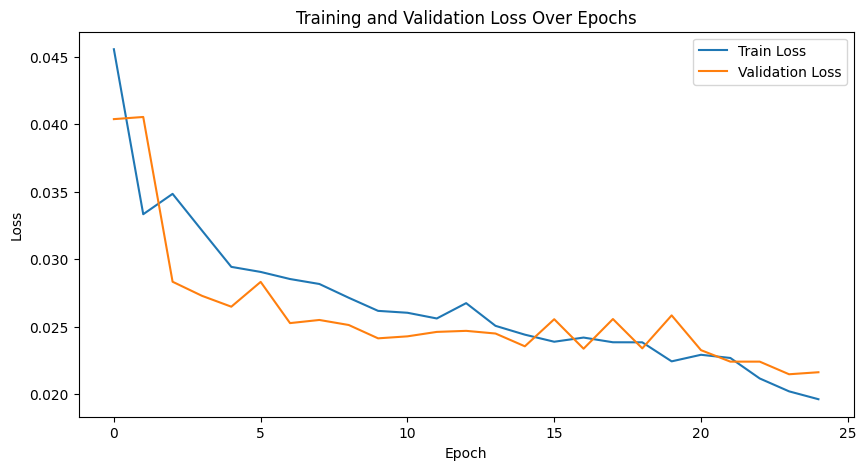

In [38]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


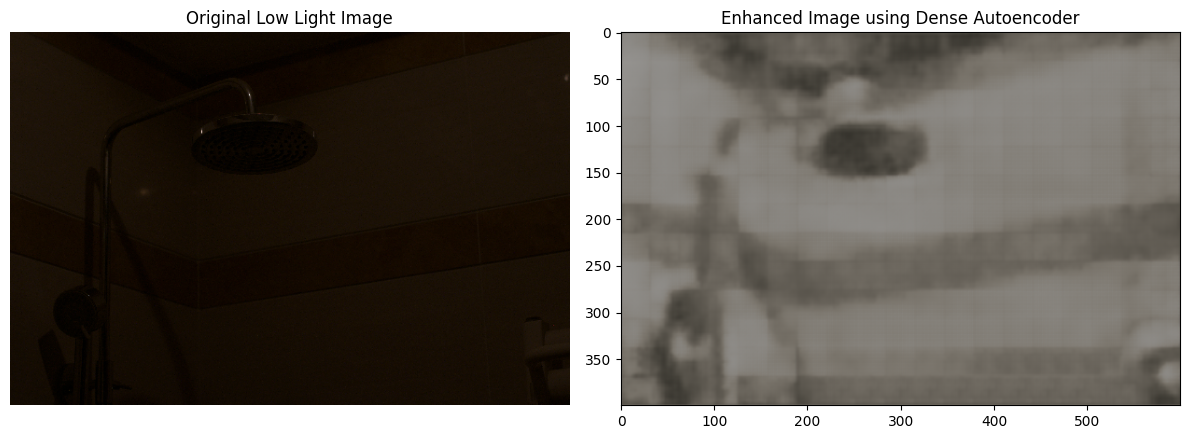

In [41]:
sample_index = 1
sample_image = x_test[sample_index]

sample_image = np.expand_dims(sample_image, axis=0)
enhanced_image = dense_autoencoder.predict(sample_image)
enhanced_image = np.squeeze(enhanced_image, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_test[sample_index])
plt.title('Original Low Light Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title('Enhanced Image using Dense Autoencoder')
plt.tight_layout()
plt.show()

## Generative Adversarial Networks (GANs)

In [48]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, ReLU, BatchNormalization
from tensorflow.keras.models import Model

In [53]:
def build_GAN(input_shape):
    inputs = Input(shape=input_shape)

    # Generator
    conv1 = Conv2D(64, (4, 4), strides=2, padding='same')(inputs)
    conv1 = ReLU()(conv1)

    conv2 = Conv2D(128, (4, 4), strides=2, padding='same')(conv1)
    conv2 = BatchNormalization()(conv2)
    conv2 = ReLU()(conv2)
    
    # Decoder
    up1 = Conv2DTranspose(64, (4, 4), strides=2, padding='same')(conv2)
    up1 = ReLU()(up1)
    
    outputs = Conv2D(3, (4, 4), activation='sigmoid', padding='same')(up1)
    outputs = tf.keras.layers.Resizing(400, 600)(outputs)
    model = Model(inputs, outputs)
    return model

In [54]:
GAN = build_GAN(input_shape=(400, 600, 3))
GAN.compile(optimizer='adam', loss='mse')

In [55]:
GAN.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)           │ (None, 400, 600, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_29 (Conv2D)                   │ (None, 200, 300, 64)        │           3,136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_3 (ReLU)                       │ (None, 200, 300, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_30 (Conv2D)                   │ (None, 100, 150, 128)       │         131,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 100, 150, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_4 (ReLU)                       │ (None, 100, 150, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_19                  │ (None, 200, 300, 64)        │         131,136 │
│ (Conv2DTranspose)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_5 (ReLU)                       │ (None, 200, 300, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_31 (Conv2D)                   │ (None, 200, 300, 3)         │           3,075 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resizing_1 (Resizing)                │ (None, 400, 600, 3)         │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 269,059 (1.03 MB)

 Trainable params: 268,803 (1.03 MB)

 Non-trainable params: 256 (1.00 KB)

In [56]:
history = GAN.fit(x_train, y_train, epochs=25, batch_size=4, validation_data=(x_test, y_test))

Epoch 1/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 14s 99ms/step - loss: 0.0263 - val_loss: 0.0441
Epoch 2/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0230 - val_loss: 0.0367
Epoch 3/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 70ms/step - loss: 0.0216 - val_loss: 0.0346
Epoch 4/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0205 - val_loss: 0.0300
Epoch 5/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0224 - val_loss: 0.0245
Epoch 6/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0224 - val_loss: 0.0207
Epoch 7/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 74ms/step - loss: 0.0210 - val_loss: 0.0228
Epoch 8/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 73ms/step - loss: 0.0201 - val_loss: 0.0198
Epoch 9/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 72ms/step - loss: 0.0206 - val_loss: 0.0248
Epoch 10/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0222 - val_loss: 0.0212
Epoch 11/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.0206 - val_loss: 0.0227
Epoch 12/25
97/97 ━━━━━━━━━━━━━━━━━━━━ 7s 71ms/step - loss: 0.

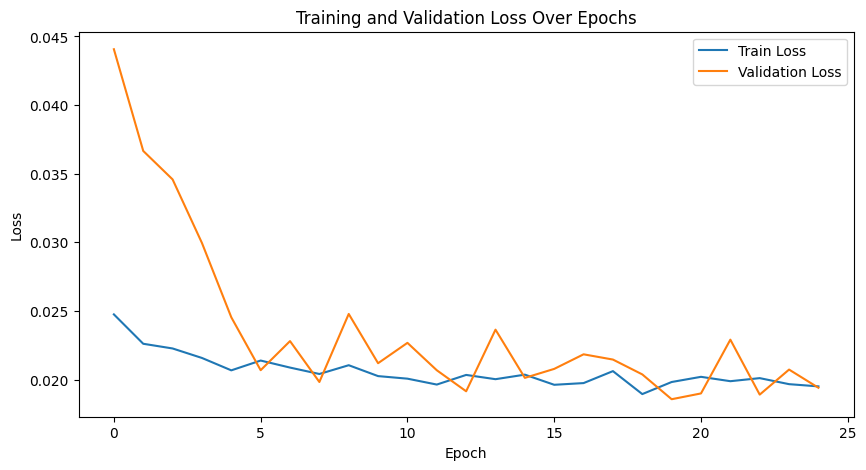

In [57]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


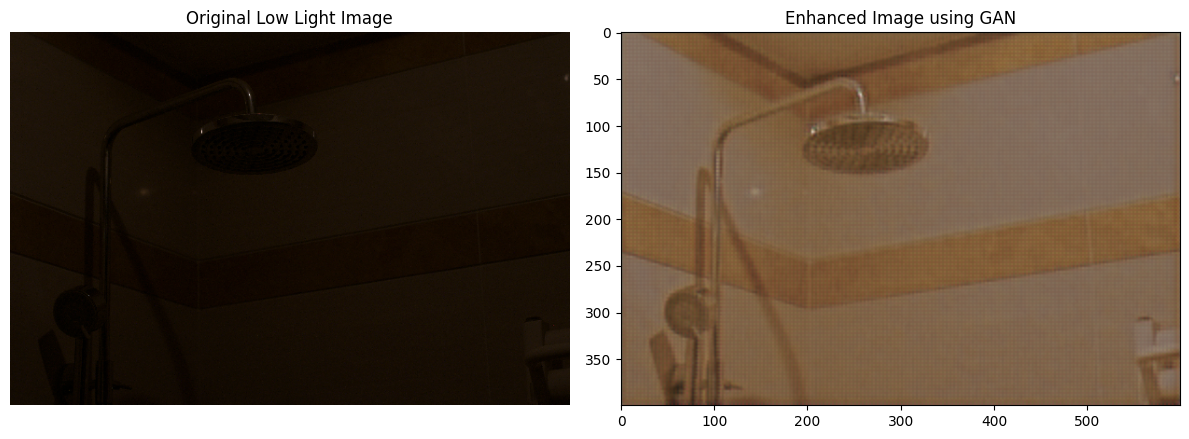

In [58]:
sample_index = 1
sample_image = x_test[sample_index]

sample_image = np.expand_dims(sample_image, axis=0)
enhanced_image = GAN.predict(sample_image)
enhanced_image = np.squeeze(enhanced_image, axis=0)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(x_test[sample_index])
plt.title('Original Low Light Image')
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(enhanced_image)
plt.title('Enhanced Image using GAN')
plt.tight_layout()
plt.show()